# This is the jupyter Notebook which will do the final data-analysis. It will do the tasks necessary for Phase 1:

## 1) Give all Trimble readings (ID_track) a score. According to GPS_classification_15.11.txt

## 2) Pick out the best reading (ID_track) to use where multiple readings are available for the same plant ID.

### Input: The data tables for every year from Phase 0/ November/ Version 3

### Output: 
1) The original data tables with the score for each ID_track

2) A data table that containts the best reading (ID_track) for every Sample


@ Author: Harald Ringbauer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cPickle as pickle
import itertools
import simplekml
import math
from pyproj import Proj  # Package for doing GPS-calculations and Projections
from collections import Counter

# Prepare the Longitude/Latitude to Easting/Northing transformer
my_proj = Proj(proj='utm', 
               zone="31T", ellps='WGS84', units='m')  

In [2]:
# A few global Variable names.
# String of the Names of all Input Files:
file_names = ["Antspec2009_IDtrack_DF.csv","Antspec2010_IDtrack_DF.csv","Antspec2011_IDtrack_DF.csv",
              "Antspec2012_IDtrack_DF.csv","Antspec2013_IDtrack_DF.csv","Antspec2014_IDtrack_DF.csv"] 

output_file_name = "Antspec_compl.csv"
id_track_decision_output_file_name = "ID_track_decision.csv"

input_folder =  "./Input_Data/"    # Name of the Folder used for Input Files
output_folder = "./Output_Data/"

In [3]:
data_tables = []   # List into which all data_tables will go.
all_data = []      # Data Frame for all the Data
headers = []       # List into which all headers will go.


for file_name in file_names:
    path = input_folder + file_name
    print("\nLoading " + path)
    data = np.genfromtxt(path, delimiter = '$', dtype=None)
    print("Shape of Data: ")
    print(data.shape)
    df = pd.read_csv(input_folder + file_name, delimiter="$")     # Create Panda Data Frame
    data_tables.append(df)                                        # Append Panda Data 
    headers.append(list(df))
    
print("\n%i Files successfully loaded!" % len(data_tables))      # Quick Status Update

# Quickly check whether all headers are the same:
for i in range(1,len(headers)):
    equal=np.array_equal(headers[i-1], headers[i])
    if equal == False:
        raise ValueError("Not all headers are equal!")
print("All headers equal!")

print("\nData Format: ")
df = data_tables[0]
print(df.dtypes)

# Concatenate all the data into a single data Frame
print("\nMerging all the data!")
all_data=pd.concat(data_tables, axis=0, ignore_index=1) # Concatenate all Data; Ignore Indexing
print("Nr. of all individuals: %i" % all_data.shape[0])
all_data.reset_index(drop=1)
all_data.reset_index()
all_data.head(3)
#all_data


Loading ./Input_Data/Antspec2009_IDtrack_DF.csv
Shape of Data: 
(1925, 27)

Loading ./Input_Data/Antspec2010_IDtrack_DF.csv
Shape of Data: 
(3119, 27)

Loading ./Input_Data/Antspec2011_IDtrack_DF.csv
Shape of Data: 
(2569, 27)

Loading ./Input_Data/Antspec2012_IDtrack_DF.csv
Shape of Data: 
(3741, 27)

Loading ./Input_Data/Antspec2013_IDtrack_DF.csv
Shape of Data: 
(5758, 27)

Loading ./Input_Data/Antspec2014_IDtrack_DF.csv
Shape of Data: 
(8715, 27)

6 Files successfully loaded!
All headers equal!

Data Format: 
Population                object
Location                  object
VisitID                    int64
PlantID                   object
IDtrack                   object
PhenoCat                 float64
Date                      object
year                       int64
ThisYearLabel              int64
Latitude                 float64
Longitude                float64
Altitude                 float64
CorrectedLatitude        float64
CorrectedLongitude       float64
CorrectedAltitude 

,Population,Location,VisitID,PlantID,IDtrack,PhenoCat,Date,year,ThisYearLabel,Latitude,...,DistEastofCentre,DistNorthOfCentre,HorzErr,VertErr,GPS,Comments,Alive,Perennial,FloweringStage,LocationManualUpdater
0,HZ,Unk,2022.0,J0001,1_J0001,NaN,16/06/09,2009,1.0,42.321497,...,-232.275681,-131.158978,5.95776,9.13216,1.0,NaN,Alive,NaN,NaN,NaN
1,HZ,Unk,2023.0,J0002,2_J0002,NaN,16/06/09,2009,1.0,42.321479,...,-233.310219,-133.051083,5.92379,8.82668,1.0,NaN,Alive,NaN,NaN,NaN
2,HZ,Unk,2024.0,J0003,3_J0003,NaN,16/06/09,2009,1.0,42.321529,...,-241.008310,-127.430149,7.18771,9.08730,1.0,NaN,Alive,NaN,NaN,NaN


In [4]:
#### Now do the ID - Track Score for Every single individual:
all_data['Track_Score']=-1 # Set the Default Track Score to 0!
un_corr_df = all_data.loc[:,['Latitude','Longitude','Altitude']]                          # The uncorrected Data
corr_df = all_data.loc[:,['CorrectedLatitude','CorrectedLongitude','CorrectedAltitude']]  # The corrected Data                                  # The corrected Data


un_corr_df.Longitude = un_corr_df.Longitude.round(8)  # Cut significants digits (due to weird bug)
corr_df.CorrectedLongitude = corr_df.CorrectedLongitude.round(8) # Cut significant digits (due to weird bug)


# Extract the indices where Nan
nan_corr = corr_df.isnull().any(axis=1)   # Get all indices were at least one entry is not 0.
nan_uncorr = un_corr_df.isnull().any(axis=1)   # Get all indices were at least one entry is not 0.

# Some logical magic to find out where one entry is 
both_nan = nan_corr & nan_uncorr
one_nan = ~nan_corr & nan_uncorr   # Corrected Value is not NaN, but uncorrected is!
non_nan = ~nan_corr & ~nan_uncorr  # Both are not NaN


# Give some Output
print("Nr. of NaNs in uncorrected: %i" % np.sum(list(nan_uncorr)))
print("Nr. of NaNs in corrected: %i" % np.sum(list(nan_corr)))
print("Nr. of NaNs in both: %i" % np.sum(list(both_nan)))

# Extract where the two Position-Frames differ:
diff_pos = (un_corr_df.values != corr_df.values).any(axis=1)  # Numpy Array where GPS positions different
same_pos = np.logical_not(diff_pos)
print("Nr. Entries where GPS Entries are different: %i out of %i" % (np.sum(list(diff_pos)), corr_df.shape[0]))

bd = non_nan & diff_pos
bs = non_nan & same_pos

# Extract where someone did a manual Update:
manual_updater = ~all_data.LocationManualUpdater.isnull()   # Extract all entries where there is a manual Updater
print("Nr. of Entries with manual positon update:  %i out of %i" % (np.sum(list(manual_updater)), corr_df.shape[0]))

# Extract where death or label only:
plant_stat_wrong = (all_data.Alive == "Label only") | (all_data.Alive == "Dead")
print("Nr. of Entries with Death or Label Only:  %i out of %i" % (np.sum(list(plant_stat_wrong)), corr_df.shape[0]))

# Do the classification per year
first_chars = all_data.PlantID.str[0].values # First Character for every year
years = all_data.year.values      # Year 
#print(set(first_char))  # The C comes from Cadi
#print(set(year))        # The year

char = ['J', 'K'  , 'L' ,'M' , 'P', 'S', 'C']  # Start with creating a dictionary:
year = [2009, 2010, 2011, 2012, 2013, 2014, 2014]
d = dict(zip(char, year))

transf_year = np.array([d[i] for i in first_chars])  # Put first chars through dictionary

same_year = (transf_year == years)
same_year[first_chars=='C']= 1  # Set all Cadi Plants to this year

print("\nPlants from the same year %i:" %np.sum(same_year))
print("Plants from the same year according to label: %i" %np.sum(all_data.ThisYearLabel))

diff = (same_year != all_data.ThisYearLabel.values)
#print(all_data.loc[diff,'PlantID']) # Print Differences between inferred difference and ThisYearLabel.values




############################ Actually set the entries
#print(np.sum(list(one_nan)))
all_data.loc[both_nan,'Track_Score'] = 0  # Set the lowest Score
all_data.loc[one_nan,'Track_Score'] = 1   # Set Score = 1: Corrected is not NaN, but Uncorrected is!
all_data.loc[bs,'Track_Score'] = 2        # Both Entries exist - but are the same
all_data.loc[bd,'Track_Score'] = 3        # High score: Both GPS entries exist and are different

all_data.loc[manual_updater, 'Track_Score'] = 1   # Set all entries where there was an manual Updater to 1.
all_data.loc[plant_stat_wrong, 'Track_Score'] = 0 # Set all entries where the plant status is Dead/Alive to 0.

print("\nHow often do Track_Scores appear: ")
all_values = all_data.Track_Score.value_counts()
print(all_values)

all_data.to_csv(output_folder + output_file_name, sep = '$')
print("Data Saved!")
all_data.head(10)

Nr. of NaNs in uncorrected: 1792
Nr. of NaNs in corrected: 1466
Nr. of NaNs in both: 1466
Nr. Entries where GPS Entries are different: 17956 out of 25821
Nr. of Entries with manual positon update:  404 out of 25821
Nr. of Entries with Death or Label Only:  3225 out of 25821

Plants from the same year 20911:
Plants from the same year according to label: 20817

How often do Track_Scores appear: 
3    15611
2     5881
0     3923
1      406
Name: Track_Score, dtype: int64
Data Saved!


,Population,Location,VisitID,PlantID,IDtrack,PhenoCat,Date,year,ThisYearLabel,Latitude,...,DistNorthOfCentre,HorzErr,VertErr,GPS,Comments,Alive,Perennial,FloweringStage,LocationManualUpdater,Track_Score
0,HZ,Unk,2022.0,J0001,1_J0001,NaN,16/06/09,2009,1.0,42.321497,...,-131.158978,5.95776,9.13216,1.0,NaN,Alive,NaN,NaN,NaN,2
1,HZ,Unk,2023.0,J0002,2_J0002,NaN,16/06/09,2009,1.0,42.321479,...,-133.051083,5.92379,8.82668,1.0,NaN,Alive,NaN,NaN,NaN,3
2,HZ,Unk,2024.0,J0003,3_J0003,NaN,16/06/09,2009,1.0,42.321529,...,-127.430149,7.18771,9.08730,1.0,NaN,Alive,NaN,NaN,NaN,2
3,HZ,Unk,2025.0,J0004,4_J0004,NaN,16/06/09,2009,1.0,42.321466,...,-134.625329,7.96771,10.32340,1.0,NaN,Alive,NaN,NaN,NaN,2
4,HZ,Unk,2026.0,J0005,5_J0005,NaN,16/06/09,2009,1.0,42.321478,...,-133.306468,6.40977,8.79145,1.0,NaN,Alive,NaN,NaN,NaN,2
5,HZ,Unk,2027.0,J0006,6_J0006,NaN,16/06/09,2009,1.0,42.321452,...,-135.910147,5.98568,10.72680,1.0,NaN,Alive,NaN,NaN,NaN,2
6,HZ,Unk,2028.0,J0007,7_J0007,NaN,16/06/09,2009,1.0,42.321452,...,-136.158144,6.25380,10.02140,1.0,NaN,Alive,NaN,NaN,NaN,2
7,HZ,Unk,2029.0,J0008,8_J0008,NaN,16/06/09,2009,1.0,42.321443,...,-137.199351,6.01057,8.57548,1.0,NaN,Alive,NaN,NaN,NaN,2
8,HZ,Unk,2030.0,J0009,9_J0009,NaN,16/06/09,2009,1.0,42.321464,...,-134.760391,6.24966,8.67587,1.0,NaN,Alive,NaN,NaN,NaN,2
9,HZ,Unk,2031.0,J0010,10_J0010,NaN,16/06/09,2009,1.0,42.321470,...,-134.153190,6.58789,10.76770,1.0,NaN,Alive,NaN,NaN,NaN,2


## Step 2 of Phase 1.
Script for the ID Track decision.

In [5]:
# First load the Data Frame
df = pd.read_csv(output_folder + output_file_name, sep="$")     # Create Panda Data Frame of all merged individuals
print("Successfully loaded\n")
print("Shape of Data: ")
print(df.shape)

# First do some statistics to get an overview over the Problem:
counts=df['PlantID'].value_counts()
max_counts = max(counts)
print(counts[:5])
bins = np.arange(-0.5,max_counts+0.5,1)

plt.figure()
plt.hist(counts, bins=bins)
plt.xlim([0,max_counts+1])
plt.xlabel("Nr of Appearance of Label")
#plt.show()

# Now extract unique ID-Labels:
unique_labels=df.PlantID.unique()
unique_labels=np.sort(unique_labels)   # Sort; so that everything is easy to find.
print("Nr of unique Labels: %i" % len(unique_labels))
print("Nr of total Labels: %i" % len(df))

# Create a Data Frame into which finally the values are filled in; only unique Labels
dic={'PlantID': unique_labels, 'Latitude': 0, 'Longitude': 0, 'Altitude': 0, 'ID_Track Decision': 'None', 'Score': -10}
# At the end; there should be no -10 at the Score Column!!
final_decision = pd.DataFrame(dic, columns=['PlantID','Latitude','Longitude', 'Altitude', 'ID_Track_Decision', 'Score'])
final_decision.head(10)

Successfully loaded

Shape of Data: 
(25821, 29)
J1548    8
L1359    8
J1251    8
P0056    8
M0121    7
Name: PlantID, dtype: int64
Nr of unique Labels: 18215
Nr of total Labels: 25821


,PlantID,Latitude,Longitude,Altitude,ID_Track_Decision,Score
0,CADI0001,0,0,0,NaN,-10
1,CADI0002,0,0,0,NaN,-10
2,CADI0003,0,0,0,NaN,-10
3,CADI0004,0,0,0,NaN,-10
4,CADI0005,0,0,0,NaN,-10
5,CADI0006,0,0,0,NaN,-10
6,CADI0007,0,0,0,NaN,-10
7,CADI0008,0,0,0,NaN,-10
8,CADI0009,0,0,0,NaN,-10
9,CADI0010,0,0,0,NaN,-10


In [6]:
#Now write functions to set the various Values of the Data Frame:
# First, Pairwise GPS-Distance
# Whole date frame is supposed to be df (for lookup)

def GPS_Distance(coords1, coords2):
    '''Calculates pairwise GPS distance.
    coords: Arrays with Latitude, Longitude, Altitude '''
    coords1, coords2 = np.array(coords1), np.array(coords2) # Make sure that things are arrays
    
    # Check whether everything is a float as should be:
    assert(all(isinstance(item, float) for item in coords1))
    assert(all(isinstance(item, float) for item in coords2))
    
    
    lat1, lat2 = coords1[0], coords2[0]  # Load Latitude
    lon1, lon2 = coords1[1], coords2[1]  # Load Longitude
    alt1, alt2 = coords1[2], coords2[2]  # Load Altitude
    
    
    x1, y1 = my_proj(lon1, lat1)  # Transform to Meters-Coordinates
    x2, y2 = my_proj(lon2, lat2)  # Transform to Meters-Coordinates
    
    dist_eucl = np.linalg.norm([x1 - x2, y1 - y2, alt1 - alt2])  # Calculate the pairwise distance
    return dist_eucl

def look_up_plantID(plant_ID, lookup_df, col_name="PlantID"):
    '''Function that looks up plant_ID in dataframe - and returns a
    list of all indices where the plants actually appear'''
    lookup_list = lookup_df[col_name].values
    
    assert(isinstance(plant_ID, str))  # To make sure plantID is actually String
    rel_indices = np.where(lookup_list == plant_ID)[0]   
    
    return rel_indices

def set_single_plant_score(track_score):
    '''Sets the score for a single Plant.
    Simply takes track_score as input and return the corresponding values'''

    #######################################
    # Set Score 5/8: Single GPS entry with track_score 3
    if track_score == 3:
        return 5
                
    ########################################
    # Set Score 4/7: Single GPS entry with track_score 2
    elif track_score == 2:
        return 4
        
    ########################################
    # Set Score 3/6: Single GPS entry with track_score 1
    elif track_score == 1:
        return 3
    
    ########################################
    # Set Score 0: Single GPS entry with track_score 0
    elif track_score == 0:
        return 0
    
    else:
        print("Error!")
        return -1
    
    
def set_score(plantID, df):
    '''Function to set the score for plant ID using the Data-Table df
    Return final score (0-10) and IT_Track Decision'''
    assert(isinstance(plantID, str))  # To make sure plantID is actually String
    rel_indices = look_up_plantID(plantID, df)
    
    # In case Index is not there:
    if len(rel_indices) == 0:        
        print("Index not found!")
        print("Put all your shit in bag. Put it in a shit museum. I don't care! But get it together!")
        return [-1, track_id]  # -1 is the error code
    
    # First find and extract ALL matching entries
    matching_plants = df.iloc[rel_indices,:]    # Matching plants with the right PlantID; extract them.
    coords_matching = matching_plants.loc[:,['CorrectedLatitude','CorrectedLongitude','CorrectedAltitude']] 
    scores = matching_plants.Track_Score      # Extract the Scores of all matching Plants
    id_track = matching_plants.IDtrack        # Extract the IDTrack
    
    ############################################
    # Set Score 0: All GPS Entries NaN
    if np.sum(scores) == 0:  # If only Values with Track Score 0
        return [0, id_track.iloc[0]]   # Return Score 0!
    
    ############################################
    good_scores = np.where(scores>=1)[0]                      # Get the indices of actually valuable Scores
    coords_matching = coords_matching.iloc[good_scores, :]    # Extract only the useful Entries (ID_Track 1/2/3)
    scores = scores.iloc[good_scores]                      
    id_track = id_track.iloc[good_scores]                  
    
    nr_entries = len(good_scores)  # Calculate the Nr of Plants with reasonable scores (that include GPS information)
    
    if nr_entries == 1:                           # In case there is only a single useful Entry
        return [set_single_plant_score(scores.iloc[0]), id_track.iloc[0]]  # Set single Plant Score

    
    #######################################################################################
    # Now we are in the case of MULTIPLE readings with track_score >= 1
    # First filter out the fishy ones; i.e. where there are geographic mismatches
    # between score 1,2 and 3 plants
    assert(nr_entries>1)
    
    # First calculate all pairwise distances:
    loc_dist_list = []  # Empty Local Distance List
    
    for (i, j) in itertools.combinations(range(nr_entries), r=2): # Works
        coords1 = coords_matching.iloc[i,:]                                 # Ectract GPS-Coordinate 1
        coords2 = coords_matching.iloc[j,:]                                 # Extract GPS-Coordinate 2
        dist = GPS_Distance(coords1, coords2)                               # Calculate Distance between Entries
        loc_dist_list.append(dist)
        
    max_dist = max(loc_dist_list)   # Calculate the maximum of pairwise distances
    
    max_score = max(scores)        # Max Score
    highest_id = id_track.iloc[np.where(scores==max_score)[0][0]] # Get the best ID-Track for returning
    
    ########################################
    # Set Score to 1: Serious Mismatch between multiple Score 2 & 3 plants!
    if max_dist > 100:
        # Maybe do a function here that tries to resolve things if possible
        return [1, highest_id]
      
    ########################################
    # Set Score to 2: Serious Mismatch (50-100m) between Score 2 & 3 plants!
    if max_dist > 50:
        return [2, highest_id]
    
    ###########################################################################################
    # Now we are in the situation with no SERIOUS mismatches (>50m) but multiple useful entries
    assert(len(scores)>1)
    
    max_score = max(scores)        # Max Score. Only use Max-Score Individuals for decision!  
    
    ########################################
    # Set Score to 6: Multiple matching entries (<50m), and highest score 1 or 2
    if (max_score==1) or (max_score==2):
        return [1, highest_id]
        
    # Now we are in the case where highest ranking entry has score 3:
    assert(max_score==3) # We should only be here if the max. score is 3
    
    #Extract the Score 3 ID-Tracks:
    ind_score3 = np.where(scores==3)[0] # Indices where the maximum scores can be found
    matching_plants = matching_plants.iloc[ind_score3,:]
    coords_matching.iloc[ind_score3,:]
    scores = scores.iloc[ind_score3]                      
    id_track = id_track.iloc[ind_score3]


    ########################################
    # Set Score to 7: Multiple Matching Entries (<50m) with ID_Track Score 1,2,3. Only one Track_Score 3 
    if len(ind_score3)==1 and (max_score==3):    # In case there is only one individual with the max. score
        return [7, id_track.iloc[0]]
    
    # Now we are in the case of multiple entries with high quality entry (Track_Score = 3):
    # Split this up in case according to the maximum distance
    assert(len(ind_score3)>1)
    
    loc_dist_list = []
    
    for (i, j) in itertools.combinations(range(len(matching_plants)), r=2): # Works
        coords1 = coords_matching.iloc[i,:]     # Ectract GPS-Coordinate 1
        coords2 = coords_matching.iloc[j,:]     # Extract GPS-Coordinate 2
        dist = GPS_Distance(coords1, coords2)   # Calculate Distance between Entries
        loc_dist_list.append(dist)

        max_dist = max(loc_dist_list)

        if max_dist < 1.0:
            ############################################
            # Set Score 10
            # Multiple Plants with ID_Track Score 3 recorded
            # All GPS Entries are within 1 m
            return [10, id_track.iloc[0]]

        if max_dist < 5.0:
            ############################################
            # Set Score 9
            # Multiple Plants with ID_Track Score 3 recorded
            # All GPS Entries are within 5 m
            return [9, id_track.iloc[0]]

        if max_dist < 50.0:
            ############################################
            # Set Score 8
            # Multiple Plants with ID_Track Score 3 recorded
            # All GPS Entries are within 50 m
            return [8, id_track.iloc[0]]
                    
    print("WUBBA LUBBA DUB DUB \nSomething is seriously wrong!")
    return ([-1, id_track_iloc[0]])

    ############################################
    # Set Score of Plants to 2: Best Guess 
    # GPS Reading, but plant is likely mislabeld. Could be accurate, but resolution
    # Speculative
     
#set_score("J1548")
set_score("S2801", df)

[9, '22734_S2801']

In [7]:
# Code that looks up the ID_Track Decision for every single plant:
# Assumes df is the full Data-Frame
# Assumes final_decision is the data_frame into which one writes in the end:
#score_decision = [ for i in]
print("Doing ID-Track Decisions...")
final_dec = np.array([set_score(i, df) for i in final_decision.PlantID])  # Takes about 30 secs to run
print("Done. ")

score_vec, id_track_dec = final_dec[:, 0], final_dec[:, 1]     # Extract score and id_track
final_decision.Score = score_vec                               # Set the Score 
final_decision.ID_Track_Decision = id_track_dec                # Set the ID-Track

# Write a function that finds Latitude/Longitude/Altitude:
def geo_info(iD_Track, df):
    '''Finds the Latitude, Longitude, Altitude for a given iD_Track in Dataframe df'''
    index = np.where(df.IDtrack.values == iD_Track)[0]
    assert(len(index)==1)  # Requires that the length of the Index List is one. If more we have a Problem
    coords_corr = df.loc[index[0], ['CorrectedLatitude','CorrectedLongitude','CorrectedAltitude']]
    return coords_corr.values

print("Extracting the right coordinates...")
coordinates = np.array([geo_info(i, df) for i in final_decision.ID_Track_Decision])
print("Done. ")
final_decision.loc[:,['Latitude','Longitude','Altitude']]=coordinates
final_decision.head(10)

# Write a quick script to set 6681 to 6700 to Final Score 0 (this was unwanted Duplicates!!)
for i in range(6681,6701):     # Remember the Python Indexing
    plantID='S'+str(i)
    index=np.where(final_decision.PlantID==plantID)[0][0]
    final_decision.loc[index,'Score']=0
print("Saving...")


final_decision.to_csv(output_folder + id_track_decision_output_file_name, sep = '$')
print("Done. ")

Doing ID-Track Decisions...
Done. 
Extracting the right coordinates...
Done. 
Saving...
Done. 


In [8]:
#print([i for i in final_dec])
# Do Statistics on the Score-Vector
print(Counter(score_vec))  # Print Counter how often everything was scored!
final_decision.head(10)
print("Total length of data: %i" %len(final_decision))

Counter({'5': 12028, '4': 2620, '7': 1528, '1': 601, '8': 361, '3': 338, '9': 311, '0': 237, '2': 119, '10': 72})
Total length of data: 18215


In [9]:
# Extract GPS-Coordinates for Map:
# Not Necessary for correction; it is just a nice toy
# Assume data-frame is final_decision
# 
google_map_file_name =  "final_scores.kml"
######################################################## Style Files
style = simplekml.StyleMap()  # Create a style map for highlight style and normal style FOR UNCORRECTED
style.normalstyle.labelstyle.scale = 0
style.normalstyle.iconstyle.icon.href = "http://maps.google.com/mapfiles/kml/paddle/wht-blank.png"
style.highlightstyle.labelstyle.scale = 1
style.highlightstyle.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/pushpin/blue-pushpin.png'

style2 = simplekml.StyleMap()  # Create a style map for highlight style and normal style FOR UNCORRECTED
style2.normalstyle.labelstyle.scale = 0
style2.normalstyle.iconstyle.icon.href = "http://maps.google.com/mapfiles/kml/paddle/ylw-blank.png"
style2.highlightstyle.labelstyle.scale = 1
style2.highlightstyle.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/pushpin/blue-pushpin.png'

style3 = simplekml.StyleMap()  # Create a style map for highlight style and normal style FOR UNCORRECTED
style3.normalstyle.labelstyle.scale = 0
style3.normalstyle.iconstyle.icon.href = "http://maps.google.com/mapfiles/kml/paddle/orange-blank.png"
style3.highlightstyle.labelstyle.scale = 1
style3.highlightstyle.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/pushpin/blue-pushpin.png'

style4 = simplekml.StyleMap()  # Create a style map for highlight style and normal style FOR UNCORRECTED
style4.normalstyle.labelstyle.scale = 0
style4.normalstyle.iconstyle.icon.href = "http://maps.google.com/mapfiles/kml/paddle/grn-blank.png"
style4.highlightstyle.labelstyle.scale = 1
style4.highlightstyle.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/pushpin/blue-pushpin.png'
############################################################
def set_score_style(score):
    '''Short function that sets the style for every score'''
    score=int(score)

    if score<=2:     # GPS Mismatch
        return style

    if score <= 5:  # Single GPS Entry
        return style2

    if score <= 8:  # Multiple GPS Entries
        return style3

    if score > 8:    # Great Entry
        return style4


    print("This was not supposed to happen!")
    return 0

class KML_extractor(object):
    '''
    Class containing various methods to export to google Earth.
    '''
    kml = 0

    def __init__(self):
        '''
        Constructor.
        '''
        print("Google-Maps Extractor successfully loaded!")
        # my_proj = Proj(proj='utm',zone="31T",ellps='WGS84',units='m')   # Prepare the Longitude/Latidude to Easting/Northing transformation


    def create_kml(self, names, coords, scores, output_path):
        '''Method to extract  Google Earth Data'''
        kml = simplekml.Kml()  # Load the KML Creater
        

       
        for i in range(len(names)):
            if math.isnan(coords[i, 0]):   # Check for nans
                continue  # Stop if GPS-data marked missing 
            # Coords: Longitude - Latitude - Altitude    
            pnt = kml.newpoint(name=names[i], coords=[tuple(coords[i, :])]) 
            pnt.stylemap = set_score_style(scores[i])
            pnt.comment = str(scores[i])
            pnt.altitudemode = 'absolute'
            pnt.extrude = 1

        kml.save(output_path)

        
kml_extractor = KML_extractor() # Create the KML Extractor
 
coords = final_decision.loc[:, ['Longitude','Latitude','Altitude']].values   # Notice that Longitude and Latitude are swapped
#good_inds = ~coords.isnull().any(axis=1) # Extract only values with actual coordinates

names = final_decision.PlantID.values
scores = final_decision.Score.values

print("Creating .kml")

kml_extractor.create_kml(names, coords, scores, output_folder + google_map_file_name)
print(google_map_file_name + " successfully created! ")

Google-Maps Extractor successfully loaded!
Creating .kml
final_scores.kml successfully created! 


## Test Area
Created to play around with and try out stuff.

In [18]:
print("Hello World")

Hello World


Small Script that calculates all pairwise Distances of all plants and plots and gives information about their distribution:

Doing Step: 0 
Doing Step: 500 
Doing Step: 1000 
Doing Step: 1500 
Doing Step: 2000 
Doing Step: 2500 
Doing Step: 3000 
Doing Step: 3500 
Doing Step: 4000 
Doing Step: 4500 
Doing Step: 5000 
Doing Step: 5500 
Doing Step: 6000 
Doing Step: 6500 
Doing Step: 7000 
Doing Step: 7500 
Doing Step: 8000 
Doing Step: 8500 
Doing Step: 9000 
Doing Step: 9500 
Doing Step: 10000 
Doing Step: 10500 
Doing Step: 11000 
Doing Step: 11500 
Doing Step: 12000 
Doing Step: 12500 
Doing Step: 13000 
Doing Step: 13500 
Doing Step: 14000 
Doing Step: 14500 
Doing Step: 15000 
Doing Step: 15500 
Doing Step: 16000 
Doing Step: 16500 
Doing Step: 17000 
Doing Step: 17500 
Doing Step: 18000 
Doing Step: 18500 
Doing Step: 19000 
Doing Step: 19500 
Doing Step: 20000 
Doing Step: 20500 
Doing Step: 21000 
Doing Step: 21500 
Doing Step: 22000 
Doing Step: 22500 
Doing Step: 23000 
Doing Step: 23500 
Doing Step: 24000 
Doing Step: 24500 
Doing Step: 25000 
Doing Step: 25500 


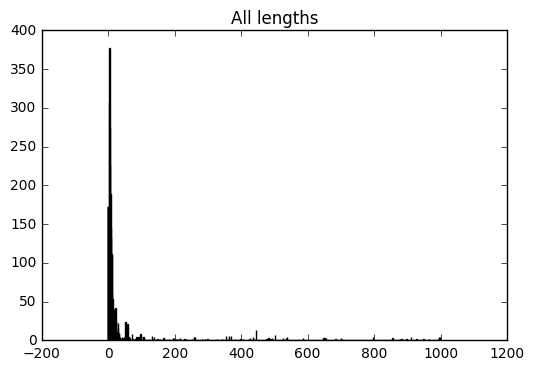

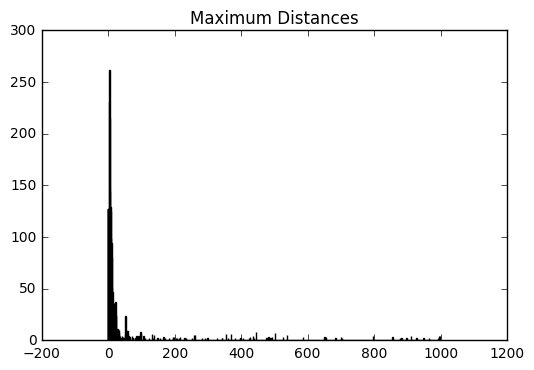

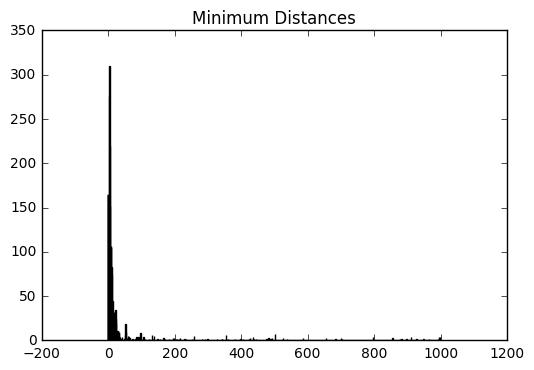

Total Number of Individuals with multiple valueable Readings: 2490
Number of Maximum Distances >500m: 180
Number of Maximum Distances >100m: 312
Number of Maximum Distances >50m: 412
Number of Maximum Distances >10m: 924

Total Number of Individuals with valuable readings where automatic resolution might be possible
Number of Maximum Distances >500m: 13
Number of Maximum Distances >100m: 24
Number of Maximum Distances >50m: 46
Number of Maximum Distances >10m: 126


In [96]:
# df is the full merged data frame
df.head(10)
counter = 0

len(df)

dist_list = []   # List where all the distances enter.
max_list = []    # List where all maximums enter.
min_list = []    # List where all minimums enter.

for plant_id in df.PlantID.iloc[:]: # Iterate over all Plant IDs
    inds=look_up_plantID(plant_id,df)
    matching_plants = df.iloc[inds,:]
    matching_plants = matching_plants[matching_plants.Track_Score>=3] # Extract plants with track_score at least 3
    
    
    #matching_plants_awesome = matching_plants[matching_plants.Track_Score==3]
    
    
    coords_matching = matching_plants.loc[:,['CorrectedLatitude','CorrectedLongitude','CorrectedAltitude']]
    
    loc_dist_list=[]

    
    # Calculate all pairwise distances:
    # Iterate over all pairs of Individuals:
    for (i, j) in itertools.combinations(range(len(matching_plants)), r=2): # Works
        coords1 = coords_matching.iloc[i,:]
        coords2 = coords_matching.iloc[j,:]
        dist = GPS_Distance(coords1, coords2)
        loc_dist_list.append(dist)

    dist_list += loc_dist_list
    
    if len(loc_dist_list)>0:
        #if np.max(loc_dist_list)>=50:  # Print Plants which are at least 50 m away from each other
            #print(plant_id)
        max_list.append(np.max(loc_dist_list))
        min_list.append(np.min(loc_dist_list))
        
                
    if counter % 500 == 0:
        print("Doing Step: %i " %counter)
    counter += 1

bins = np.linspace(-0.5, 1000.5, 1001)

plt.figure()
plt.hist(dist_list, range=[0,1000], bins=bins)
plt.title("All lengths")
plt.show()

plt.figure()
plt.hist(max_list, range=[0,1000], bins=bins)
plt.title("Maximum Distances")
plt.show()

plt.figure()
plt.hist(min_list, range=[0,1000], bins=bins)
plt.title("Minimum Distances")
plt.show()

max_dists=np.array(max_list)
min_dists=np.array(min_list)

print("Total Number of Individuals with multiple valueable Readings: %i" % len(max_dists))
print("Number of Maximum Distances >500m: %i" % np.sum(max_dists >= 500))
print("Number of Maximum Distances >100m: %i" % np.sum(max_dists >= 100))
print("Number of Maximum Distances >50m: %i" % np.sum(max_dists >= 50))
print("Number of Maximum Distances >10m: %i" % np.sum(max_dists >= 10))

# Some Statistics where resolution might be possible:
print("\nTotal Number of Individuals with valuable readings where automatic resolution might be possible")
print("Number of Maximum Distances >500m: %i" % np.sum((max_dists >= 500) * (min_dists <=10) ) )
print("Number of Maximum Distances >100m: %i" % np.sum((max_dists >= 100) * (min_dists <=10) ) )
print("Number of Maximum Distances >50m: %i" % np.sum((max_dists >= 50)* (min_dists <=10) ) )
print("Number of Maximum Distances >10m: %i" % np.sum((max_dists >= 10) * (min_dists <=10) ) )

In [132]:
# A test data frame created for playing around:
test_df = pd.DataFrame({ 'A' : 1.1111, 'B' : pd.Timestamp('20130102'), 'C' : pd.Series(1.3,index=list(range(4)),dtype='float32'),
                                      'D' : np.array([1,2,3,4],dtype='int32'),
                                      'Ea' : pd.Categorical(["test","train","test","train"]),
                                      'Fe' : 'foo' })
test_df


,A,B,C,D,Ea,Fe
0,1.1111,2013-01-02,1.3,1,test,foo
1,1.1111,2013-01-02,1.3,2,train,foo
2,1.1111,2013-01-02,1.3,3,test,foo
3,1.1111,2013-01-02,1.3,4,train,foo


In [134]:
test_df.iloc[2,3] = 5
test_df

,A,B,C,D,Ea,Fe
0,1.1111,2013-01-02,1.3,1,test,foo
1,1.1111,2013-01-02,1.3,2,train,foo
2,1.1111,2013-01-02,1.3,5,test,foo
3,1.1111,2013-01-02,1.3,4,train,foo


In [56]:
test_df[test_df.D>2]

,A,B,C,D,Ea,Fe
2,1.0,2013-01-02,1.0,3,test,foo
3,1.0,2013-01-02,1.0,4,train,foo


In [181]:
test_df = pd.DataFrame({ 'A' : 1., 'B' : pd.Timestamp('20130102'), 'C' : pd.Series(1,index=list(range(4)),dtype='float32'),
                                      'D' : np.array([3] * 4,dtype='int32'),
                                      'Ea' : pd.Categorical(["test","train","test","train"]),
                                      'Fe' : 'foo' })
test_df1 = pd.DataFrame({ 'A' : 1, 'B' : pd.Timestamp('20130102'), 'C' : pd.Series(1,index=list(range(4)),dtype='float32'),
                                      'D' : np.array([3] * 4,dtype='int32'),
                                      'Ea' : pd.Categorical(["test","train","test","train"]),
                                      'Fe' : 'foo' })
test_df1.iloc[2,3]=2.0
test_df1

a=(test_df.values!=test_df1.values).any(axis=1)
a

array([False, False,  True, False], dtype=bool)

In [6]:
a = np.array([1,2,3])
b = np.array([1,2,4])
a == b
print("Test2")

Test2


In [8]:
a = pd.DataFrame({"Test": [1,2,2,3,3,3,3]})
a["Test"].value_counts()

3    4
2    2
1    1
Name: Test, dtype: int64

In [30]:
scores = df.Track_Score
scores1 = scores[1400:1410]
print(len(scores1))

10
